In [1]:
import numpy as np
import pandas as pd
import scipy 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import datetime

from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.distributions.empirical_distribution import ECDF
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

e:\C.TSUBASA\anaconda\envs\Coursera_IBM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('Sales_Product_Price_by_Store.csv', parse_dates=['Date'])
df.head()

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
0,1,1,2010-02-05,False,9.99,7.99,245
1,1,1,2010-02-12,True,9.99,7.99,453
2,1,1,2010-02-19,False,9.99,7.99,409
3,1,1,2010-02-26,False,9.99,7.99,191
4,1,1,2010-03-05,False,9.99,9.99,145


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3861 entries, 0 to 3860
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Store              3861 non-null   int64         
 1   Product            3861 non-null   int64         
 2   Date               3861 non-null   datetime64[ns]
 3   Is_Holiday         3861 non-null   bool          
 4   Base Price         3861 non-null   float64       
 5   Price              3861 non-null   float64       
 6   Weekly_Units_Sold  3861 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3)
memory usage: 184.9 KB


In [4]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Store,3861.0,5.111111,1.0,3.0,5.0,7.0,10.0,2.767003
Product,3861.0,2.0,1.0,1.0,2.0,3.0,3.0,0.816602
Date,3861,2011-06-17 00:00:00,2010-02-05 00:00:00,2010-10-08 00:00:00,2011-06-17 00:00:00,2012-02-24 00:00:00,2012-10-26 00:00:00,NaN
Base Price,3861.0,12.554103,5.99,6.99,10.99,19.99,21.99,6.079043
Price,3861.0,11.766084,4.01,5.99,10.0,19.99,21.99,5.976196
Weekly_Units_Sold,3861.0,215.952603,13.0,69.0,130.0,278.0,2557.0,236.273397


In [5]:
df.isnull().sum()

Store                0
Product              0
Date                 0
Is_Holiday           0
Base Price           0
Price                0
Weekly_Units_Sold    0
dtype: int64

### DATA PREPROCESSING

In [6]:
df['Weekly_sales'] = df['Price'] * df['Weekly_Units_Sold']

df.set_index('Date', inplace=True)


In [7]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week_of_year'] = df.index.isocalendar().week


In [8]:
# Make new feature is promotion 
# The cheaper the price, the more weekly units were sold. is holiday or not has nothing to do with the unit sold
#df['Promotion'] = np.sign(df['Price'] - df['Base Price'])
def f(row):
    if row['Base Price'] == row['Price']:
        val =0
    elif row['Base Price'] > row['Price']:
        val =1
    else:
        val = -1
    return val 

df['Promotion'] = df.apply(f, axis=1)

### EDA

Text(0.5, 0, 'Weekly Sales')

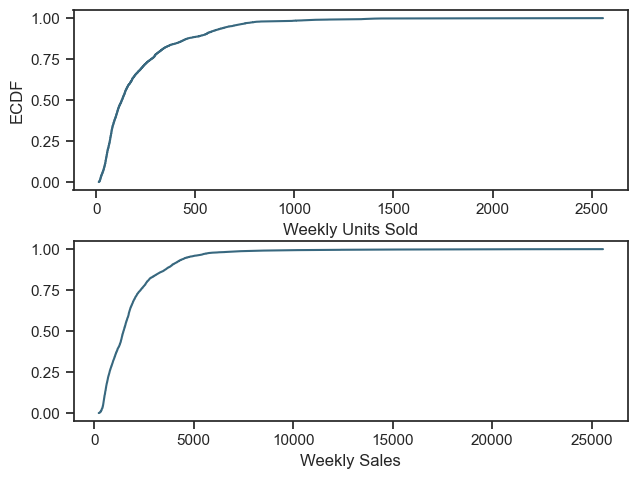

In [9]:
sns.set(style= "ticks")
plt.subplots(nrows=2, ncols=2)
plt.tight_layout()

plt.subplot(211)
cdf = ECDF(df['Weekly_Units_Sold'])
plt.plot(cdf.x, cdf.y, label= "statsmodels", color='#38687F')
plt.xlabel("Weekly Units Sold"), plt.ylabel('ECDF')

plt.subplot(212)
cdf = ECDF(df['Weekly_sales'])
plt.plot(cdf.x, cdf.y, label='statsmodels', color='#38687F')
plt.xlabel('Weekly Sales')

In [10]:
# COMPAREED Store with SALES AND SOLD
df.groupby('Store')['Weekly_sales'].sum()

Store
1      767658.68
2     1059392.94
3      287826.40
4     1320660.26
5      252647.96
6      886616.48
7      409744.36
8      580048.35
10    1756071.71
Name: Weekly_sales, dtype: float64

In [11]:
df.groupby('Store')['Weekly_Units_Sold'].sum()

Store
1      86699
2     121465
3      31689
4     158718
5      27300
6      97698
7      44027
8      65273
10    200924
Name: Weekly_Units_Sold, dtype: int64

<Figure size 1500x1000 with 0 Axes>

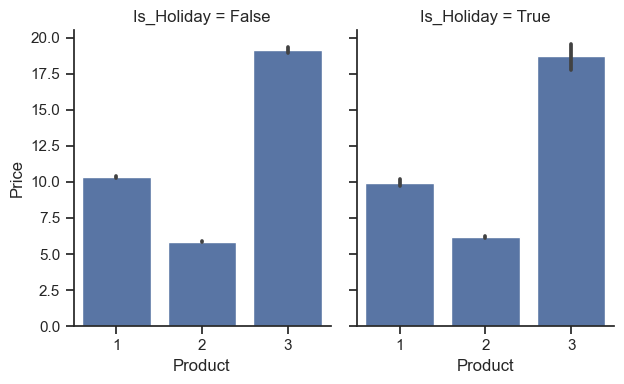

In [12]:
# Compered PRODUCT N PRICE With condition of Holiday 
plt.figure(figsize=(15,10))
sns.FacetGrid(df, col ='Is_Holiday',height=4,aspect=.8).map(sns.barplot, "Product", 'Price')


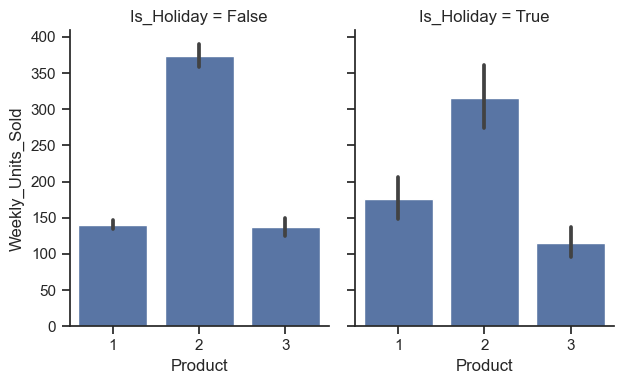

In [13]:
# Product N weekly units sold with condition Holiday
sns.FacetGrid(df, col='Is_Holiday', height=4, aspect=.8).map(sns.barplot, 'Product', 'Weekly_Units_Sold')

Product 2 is the cheapest product among these three products, so, it sells the most. Product 3 is the most expensive product among these three. Product price did not change during holidays.

Because we have recorded holidays sales, so we want to analyze if holiday contributed to the sales.

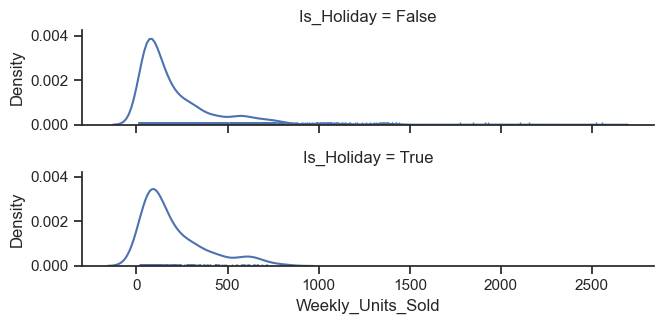

In [14]:
sns.FacetGrid(df, row="Is_Holiday",
                  height=1.7, aspect=4,).map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True);

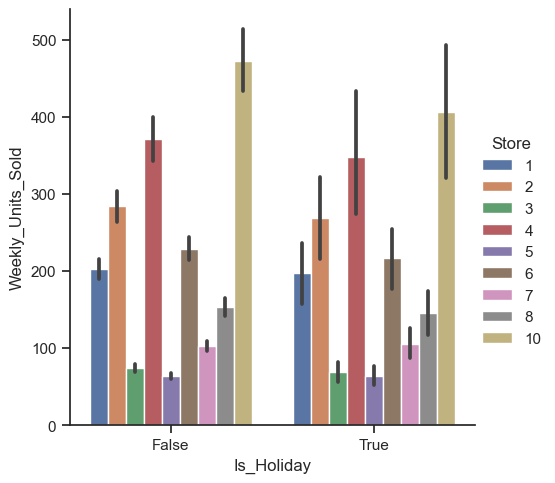

In [15]:
sns.catplot(data= df, 
               x= 'Is_Holiday',
               y= 'Weekly_Units_Sold',
               hue= 'Store',
               kind= 'bar')

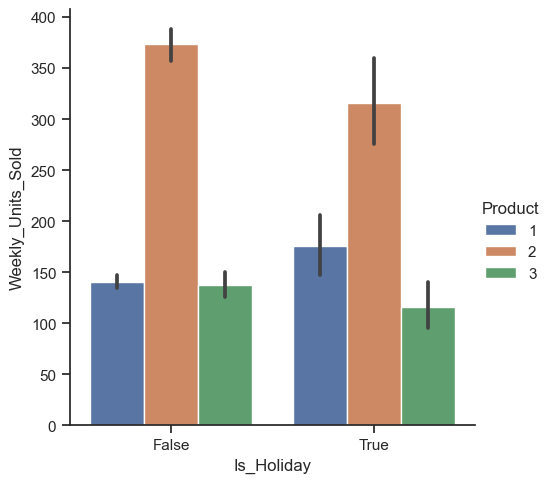

In [16]:
sns.catplot(data=df, x='Is_Holiday', y='Weekly_Units_Sold',hue='Product', kind='bar')

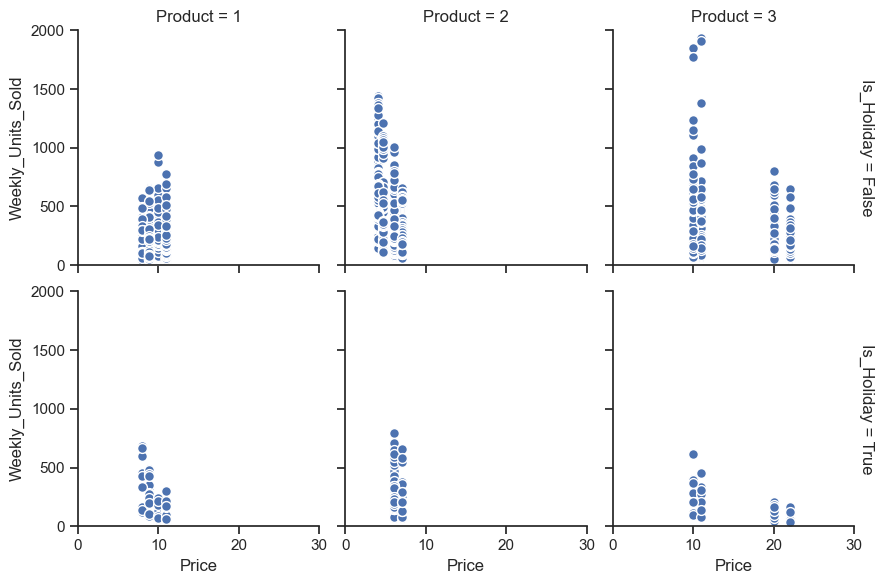

In [17]:
sns.FacetGrid(df, col='Product',row='Is_Holiday', margin_titles=True, height=3).map(plt.scatter, "Price","Weekly_Units_Sold", edgecolor="white", s=50, lw=1).set(xlim=(0,30), ylim=(0,2000))



Every product has more than one prices,both in holidays and normal days. I guess one is regular price, another is promotional price. However, the price gap for product 3 is huge, it was slashed to almost 50% off during promotions.

Product 3 made the most sales during non-holidays .

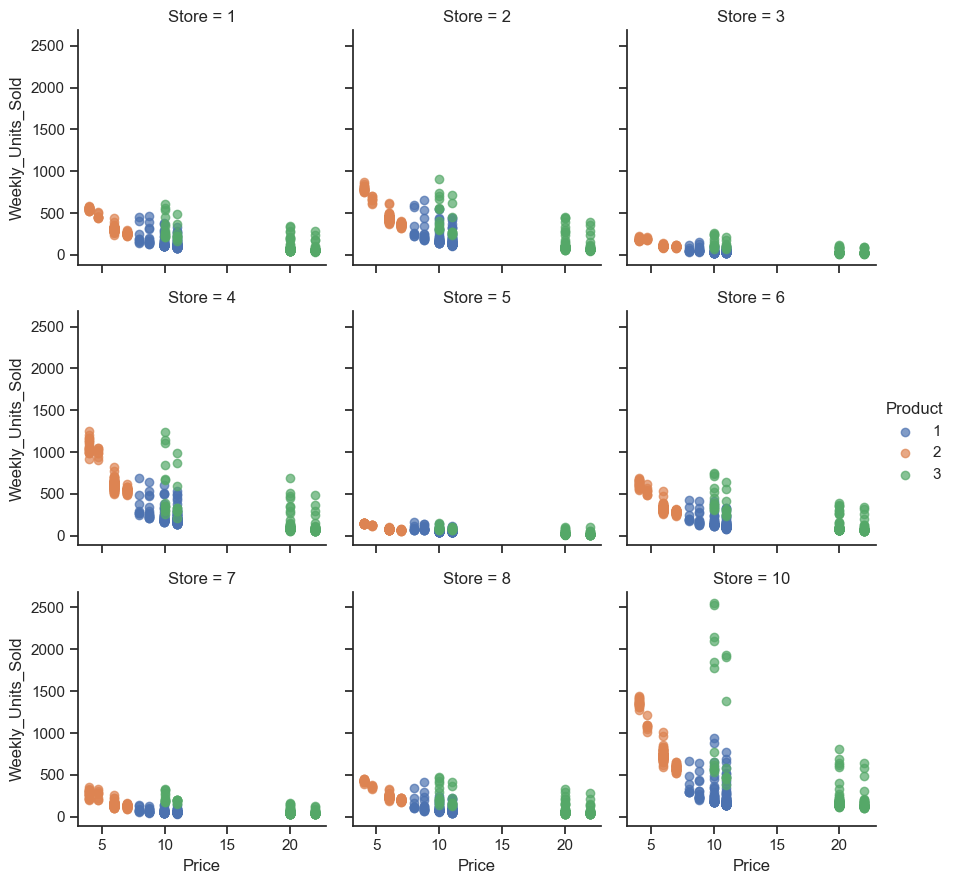

In [18]:
sns.FacetGrid(df, col='Store', hue='Product', margin_titles=True, col_wrap=3).map(plt.scatter, 'Price','Weekly_Units_Sold',alpha=.7).add_legend()

All of these 9 stores carry these three products, they all seem to have similar kind of discount promotions. However, product 3 sells the most units during promotion at store 10.

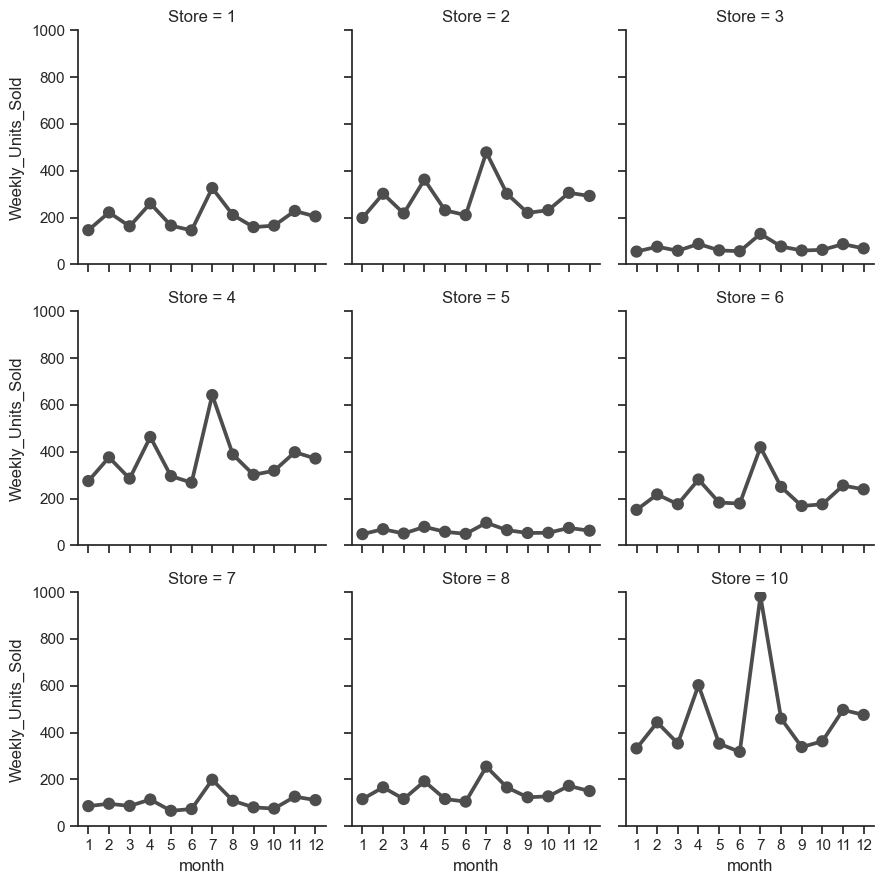

In [19]:
fig = sns.FacetGrid(df, col='Store', col_wrap=3, height=3, ylim=(0,1000))
fig.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order=[1,2,3,4,5,6,7,8,9,10,11,12])

every store has somewhat seasonality, store 10 has the most obvious seasonal pattern

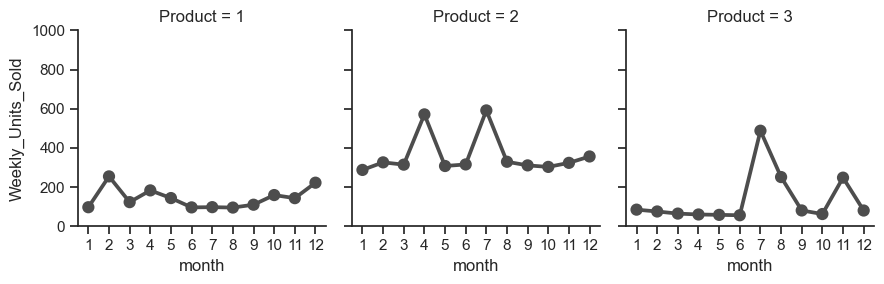

In [20]:
fig = sns.FacetGrid(df, col='Product', col_wrap=3, height=3, ylim=(0,1000))
fig.map(sns.pointplot, "month", "Weekly_Units_Sold", color=".3", ci=None, order=[1,2,3,4,5,6,7,8,9,10,11,12])

Every product has somewhat seasonality. product 3 has the most obvios seasonal pattern

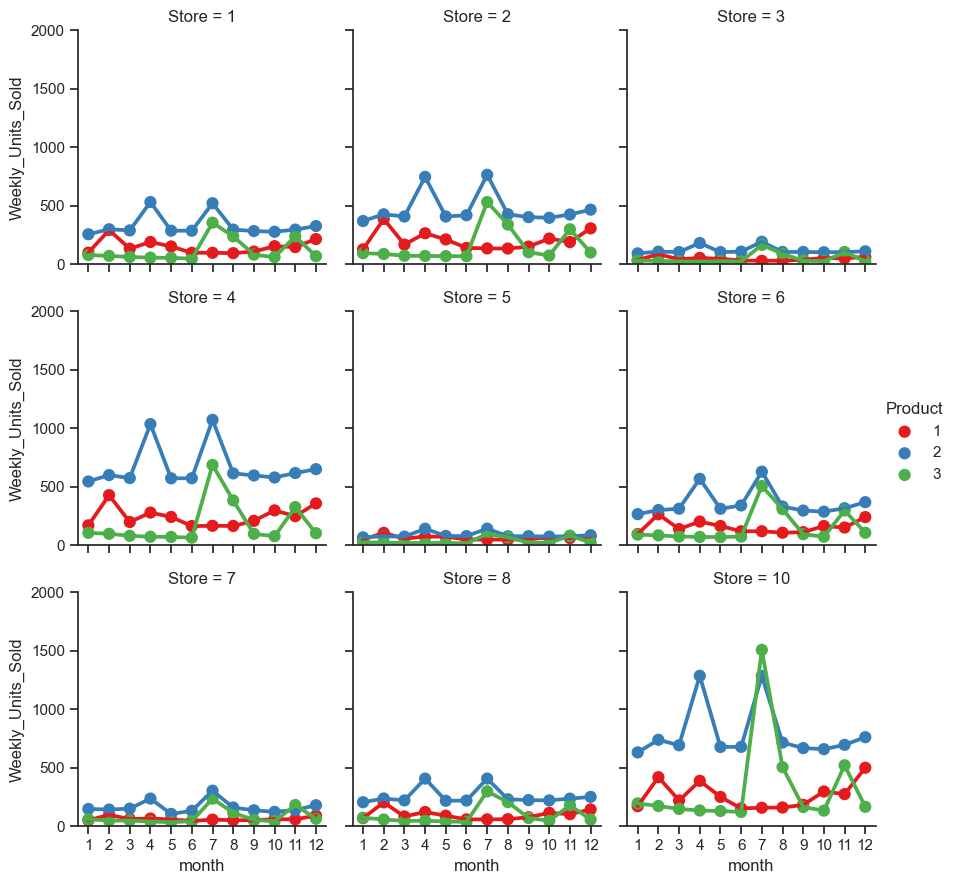

In [21]:
fig = sns.FacetGrid(df, col="Store", col_wrap=3, height=3, ylim=(0, 2000), hue='Product', palette="Set1")
fig.map(sns.pointplot, "month", "Weekly_Units_Sold", ci=None, order = [1,2,3,4,5,6,7,8,9,10,11,12])
fig.add_legend();

in general, Product 2 sells the most units at store 10. Once a While, Product 3 would exceed product 2.

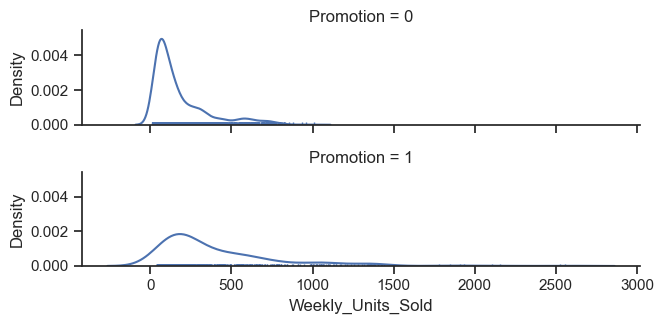

In [22]:
g = sns.FacetGrid(df, row="Promotion",
                  height=1.7, aspect=4,)
g.map(sns.distplot, "Weekly_Units_Sold", hist=False, rug=True);

it is obvious that weekly units sold are higher during the promotions

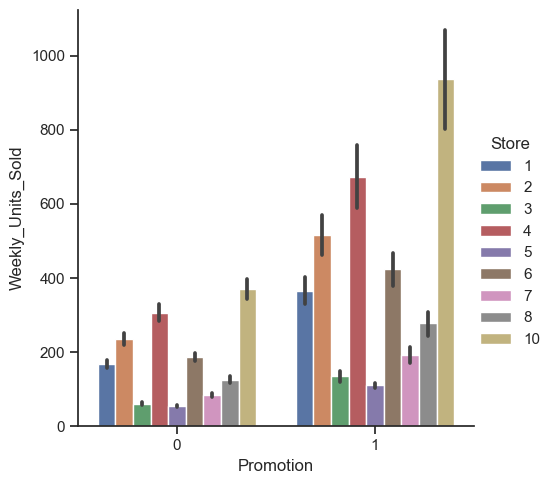

In [23]:
sns.catplot(data=df, x='Promotion', y='Weekly_Units_Sold', hue='Store', kind='bar')

Every store sells more during the promotion, there's no exception

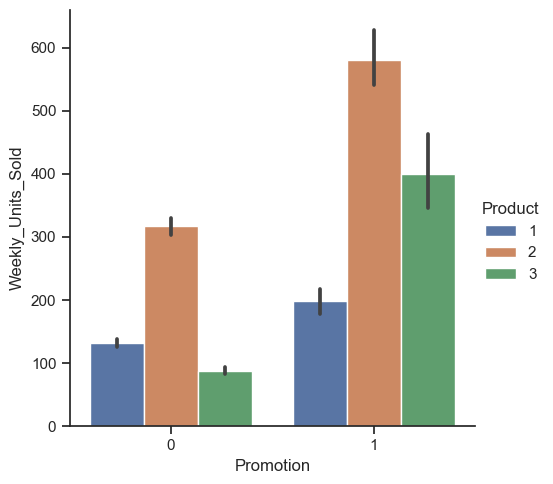

In [24]:
sns.catplot(data=df, x='Promotion', y='Weekly_Units_Sold', hue='Product', kind='bar')

Every product sells more during the promotion, in particular, product 2 and product 3

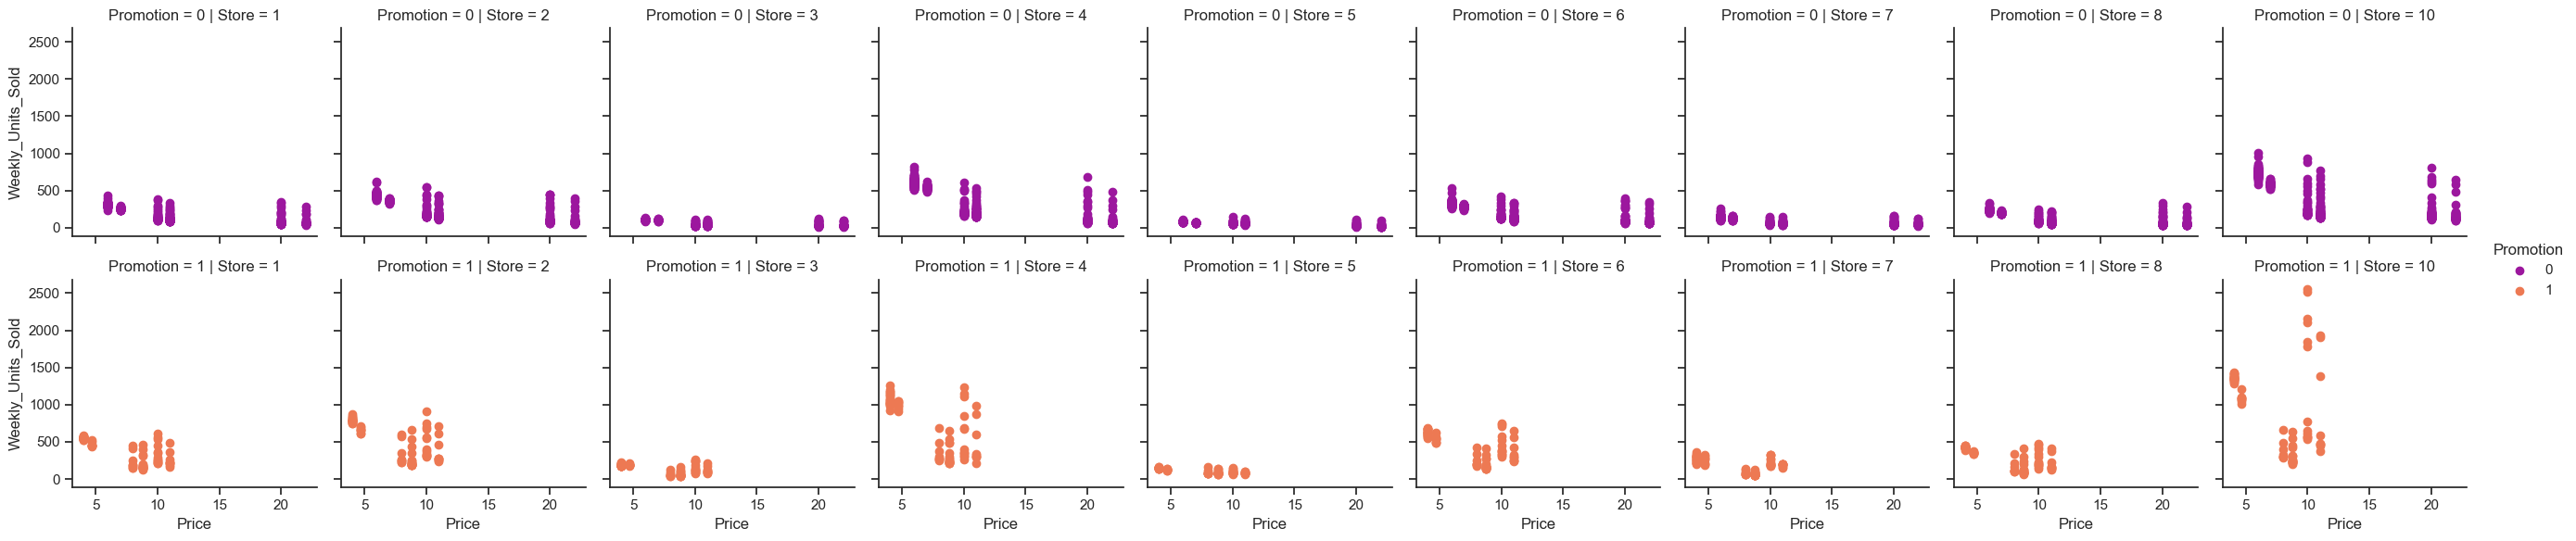

In [25]:
sns.FacetGrid(df, col='Store', hue='Promotion', palette='plasma', row='Promotion').map(plt.scatter, "Price",'Weekly_Units_Sold').add_legend()

All the stores have the similiar price promotion pattern, for some reason, store 10 sells the most during the promotions

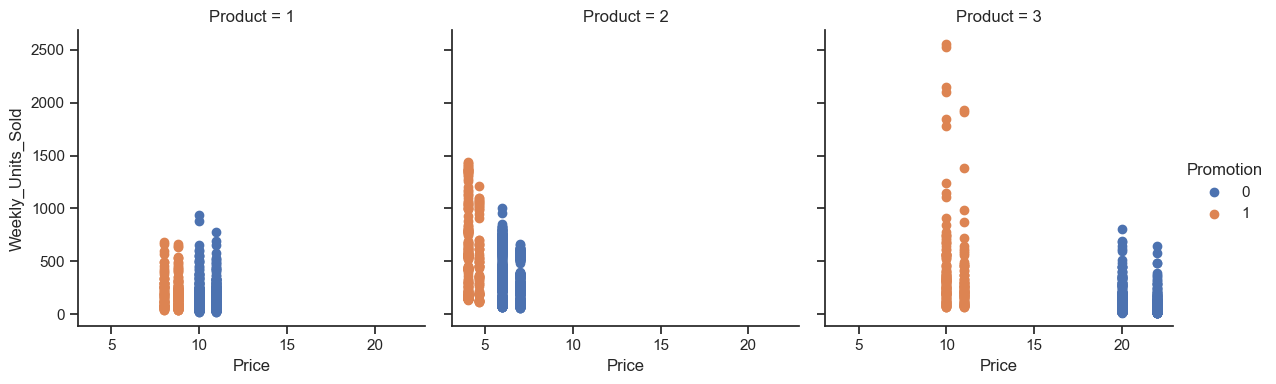

In [26]:
sns.FacetGrid(df, col='Product', hue='Promotion', height=4).map(plt.scatter, "Price",'Weekly_Units_Sold').add_legend()


all product have reguler price and promotion price. Product 3 has the highest discount and sells the most the promotions

In [27]:
# lets check average Price and weekly unit sold based product and promo.

df.groupby(['Product','Promotion'])[['Price','Weekly_Units_Sold']].mean()

Price  Weekly_Units_Sold
Product Promotion                              
1       0          10.653866         131.637722
        1           8.523333         199.171296
2       0           6.294348         317.388406
        1           4.201429         581.099206
3       0          20.700744          87.748393
        1          10.409091         400.484848

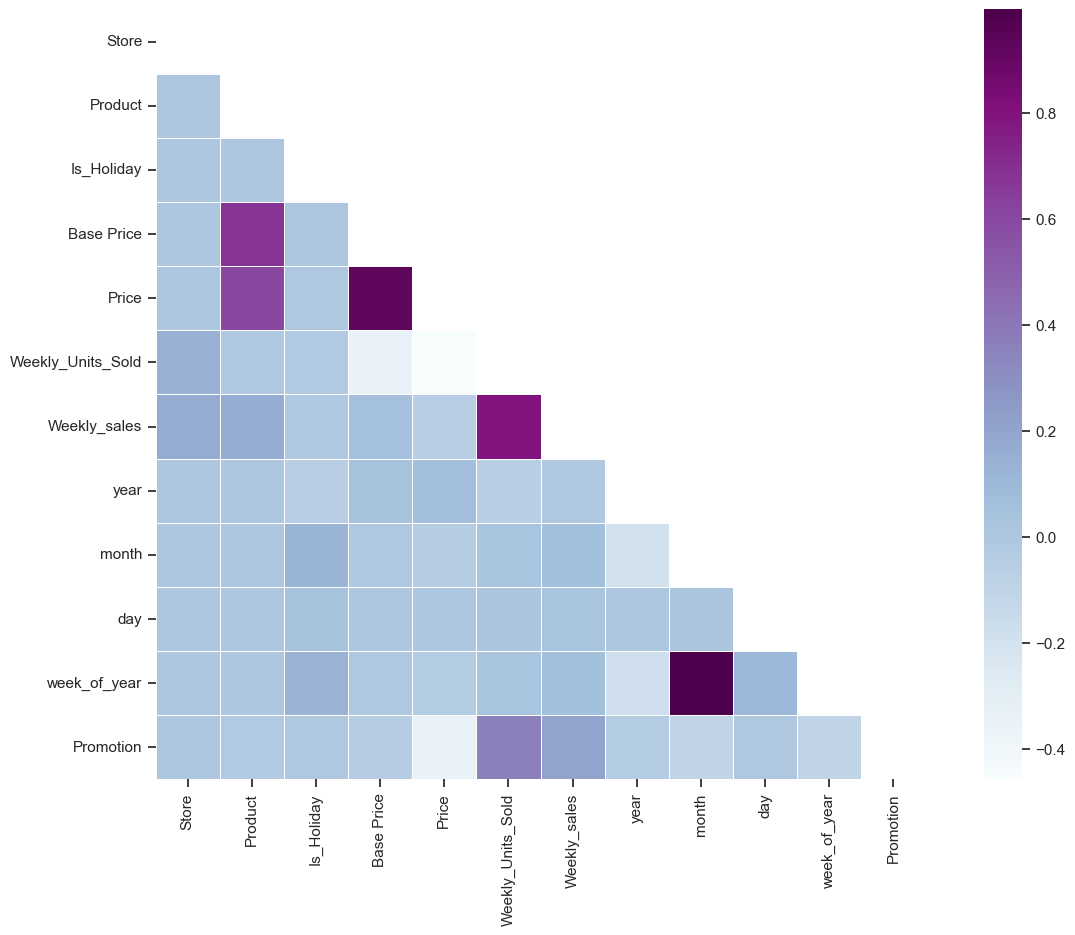

In [28]:
# lets see corelation all of feature

# generate a mask for the upper triangle
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# set up the matplotlib figure
f, ax = plt.subplots(figsize=(15,10))

# draw the heatmap with the mask and corret aspect ratio
sns.heatmap(df.corr(), mask=mask, 
            square= True, linewidths=.5, ax=ax, cmap='BuPu')

plt.show();
 

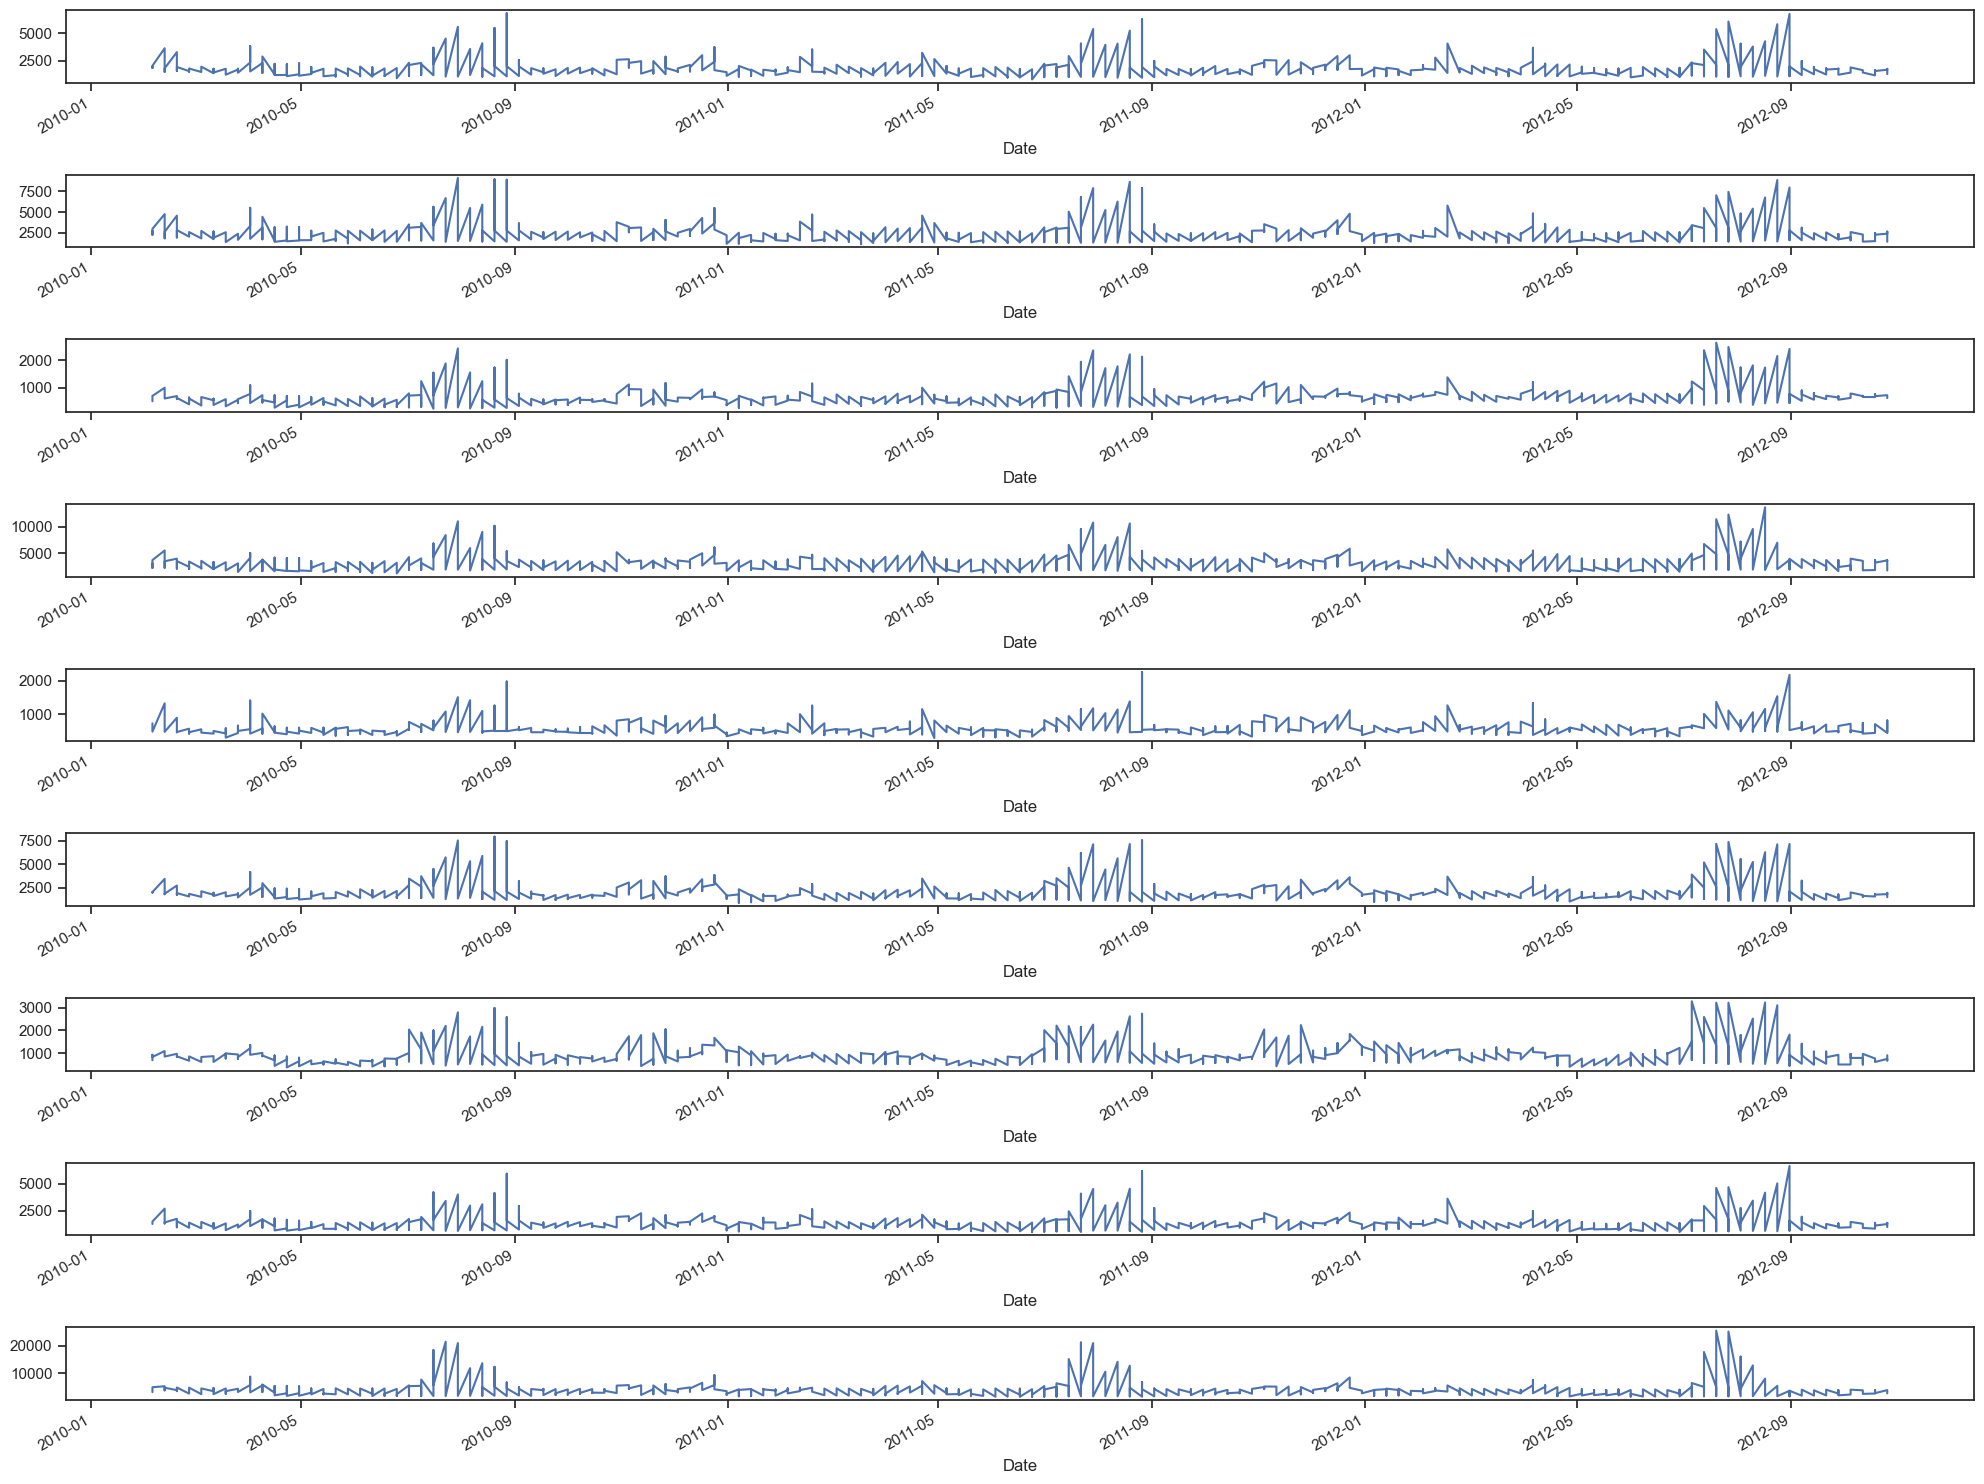

In [29]:
store_types = [1,2,3,4,5,6,7,8,10]
num_plots = len(store_types)

fig, ax = plt.subplots(num_plots, figsize=(20,15))

for i, store_types in enumerate(store_types):
    sales = df[df.Store == store_types]['Weekly_sales']
    sales.plot(ax=ax[i])

plt.tight_layout()
plt.show()

### TIME SERIES

In [30]:
# TIME SERIES

store_10_pro3 = df[(df.Store == 10) & (df.Product == 3)].loc[:, ['Base Price','Price','Weekly_Units_Sold','Weekly_sales']]
store_10_pro3.reset_index(level=0, inplace=True)

fig = px.line(store_10_pro3, x='Date', y='Weekly_sales')
fig.update_layout(title_text = 'Time Series of weekly sales')
fig.show()

In [31]:
# split data date as ds and weekly_sales as y
store_10_pro3 = store_10_pro3[['Date', 'Weekly_sales']].rename(columns={'Date':'ds', 'Weekly_sales':'y'})

# using Prophet
model = Prophet(interval_width= 0.95)
model.fit(store_10_pro3)

future_dates = model.make_future_dataframe(periods= 50, freq='W')

#future_dates.tail(10)

19:20:17 - cmdstanpy - INFO - Chain [1] start processing
19:20:17 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# predictions
forecast = model.predict(future_dates)

forecast.tail()
# predictions for last week
#forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
188,2013-09-08,4893.112154,1294.835825,6073.092768,4860.553390,4921.878397,-1189.587029,-1189.587029,-1189.587029,-1189.587029,-1189.587029,-1189.587029,0.0,0.0,0.0,3703.525125
189,2013-09-15,4892.451122,331.908209,4685.796252,4859.000980,4922.100816,-2463.762647,-2463.762647,-2463.762647,-2463.762647,-2463.762647,-2463.762647,0.0,0.0,0.0,2428.688475
190,2013-09-22,4891.790089,117.953404,4701.978637,4857.475775,4922.446424,-2503.413261,-2503.413261,-2503.413261,-2503.413261,-2503.413261,-2503.413261,0.0,0.0,0.0,2388.376828
191,2013-09-29,4891.129056,863.549509,5474.261832,4856.603893,4923.112625,-1869.288556,-1869.288556,-1869.288556,-1869.288556,-1869.288556,-1869.288556,0.0,0.0,0.0,3021.840501
192,2013-10-06,4890.468024,877.152718,5465.150896,4854.847387,4923.782205,-1731.394925,-1731.394925,-1731.394925,-1731.394925,-1731.394925,-1731.394925,0.0,0.0,0.0,3159.073099


In [33]:
# predictions for last week
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
183,2013-08-04,17096.699890,14833.164051,19321.758888
184,2013-08-11,12298.569093,9713.854366,14445.313587
185,2013-08-18,8998.368648,6524.591485,11393.299980
186,2013-08-25,7161.643792,4819.742101,9499.924612
187,2013-09-01,5543.703615,3250.547073,7994.903226
188,2013-09-08,3703.525125,1294.835825,6073.092768
189,2013-09-15,2428.688475,331.908209,4685.796252
190,2013-09-22,2388.376828,117.953404,4701.978637
191,2013-09-29,3021.840501,863.549509,5474.261832
192,2013-10-06,3159.073099,877.152718,5465.150896


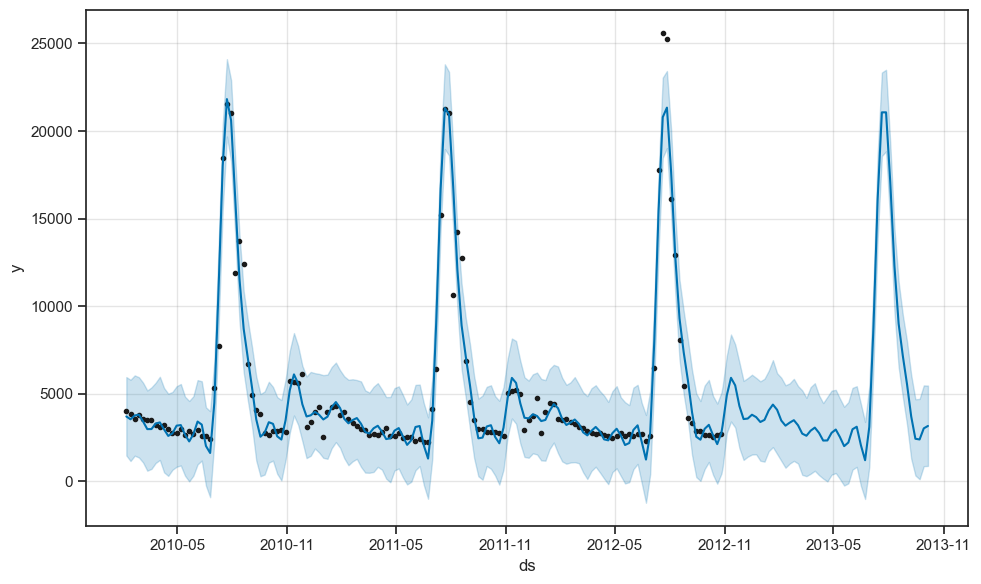

In [34]:
model.plot(forecast);

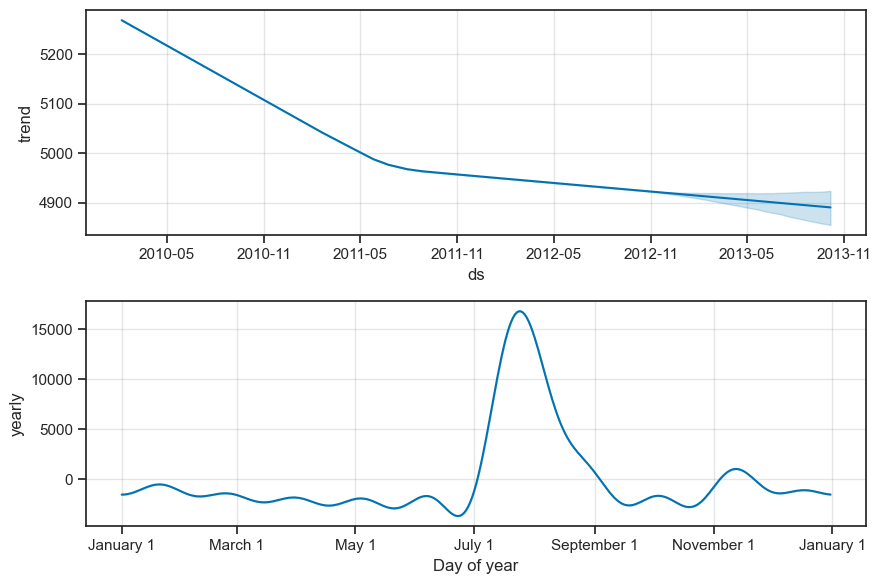

In [35]:
model.plot_components(forecast);

In [36]:
# Evaluation
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

mse= mean_squared_error(metric_df['y'], metric_df['yhat'])
print('The RMSE is {}'.format(sqrt(mse)))

The RMSE is 1190.0956217976714


In [37]:
# Add Seasonality effect

store_10_pro3['school_holiday_season'] = store_10_pro3['ds'].apply(lambda ds: datetime.date(pd.to_datetime(ds).year, 7, 1) < pd.to_datetime(ds).date() < datetime.date(pd.to_datetime(ds).year, 9, 9))
store_10_pro3['not_school_holiday_season'] = ~store_10_pro3['school_holiday_season']

model = Prophet(interval_width=0.95)

In [38]:
model.add_seasonality(name='school_holiday_season', period=365, fourier_order=3, condition_name='school_holiday_season')
model.add_seasonality(name='not_school_holiday_season', period=365, fourier_order=3, condition_name='not_school_holiday_season')
model.fit(store_10_pro3)

19:20:19 - cmdstanpy - INFO - Chain [1] start processing


19:20:20 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
forecast = model.make_future_dataframe(periods=50, freq='W')

forecast['school_holiday_season'] = forecast['ds'].apply(lambda ds: datetime.date(pd.to_datetime(ds).year, 7, 1) < pd.to_datetime(ds).date() < datetime.date(pd.to_datetime(ds).year, 9, 9))
forecast['not_school_holiday_season'] = ~forecast['school_holiday_season']


In [40]:
forecast = model.predict(forecast)

Text(0.5, 1.0, 'Weekly sales forecast')

<Figure size 1500x1000 with 0 Axes>

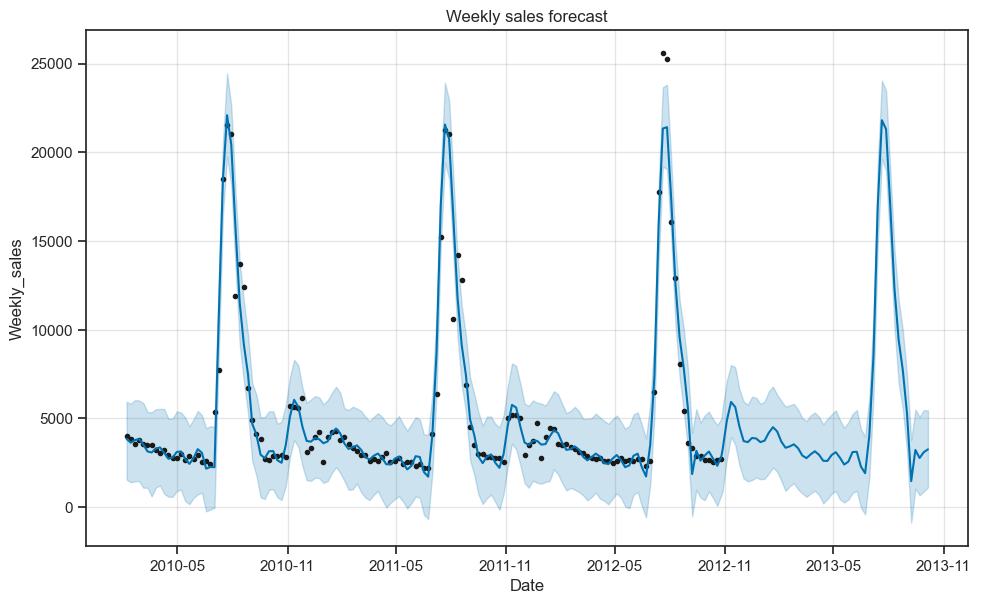

In [41]:
plt.figure(figsize=(15,10))
model.plot(forecast, xlabel='Date', ylabel='Weekly_sales')
plt.title("Weekly sales forecast")

In [42]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_pro3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
mse = mean_squared_error(metric_df.y, metric_df.yhat)
print('THE RMSE is {}'.format(sqrt(mse)))


THE RMSE is 1125.731537724772


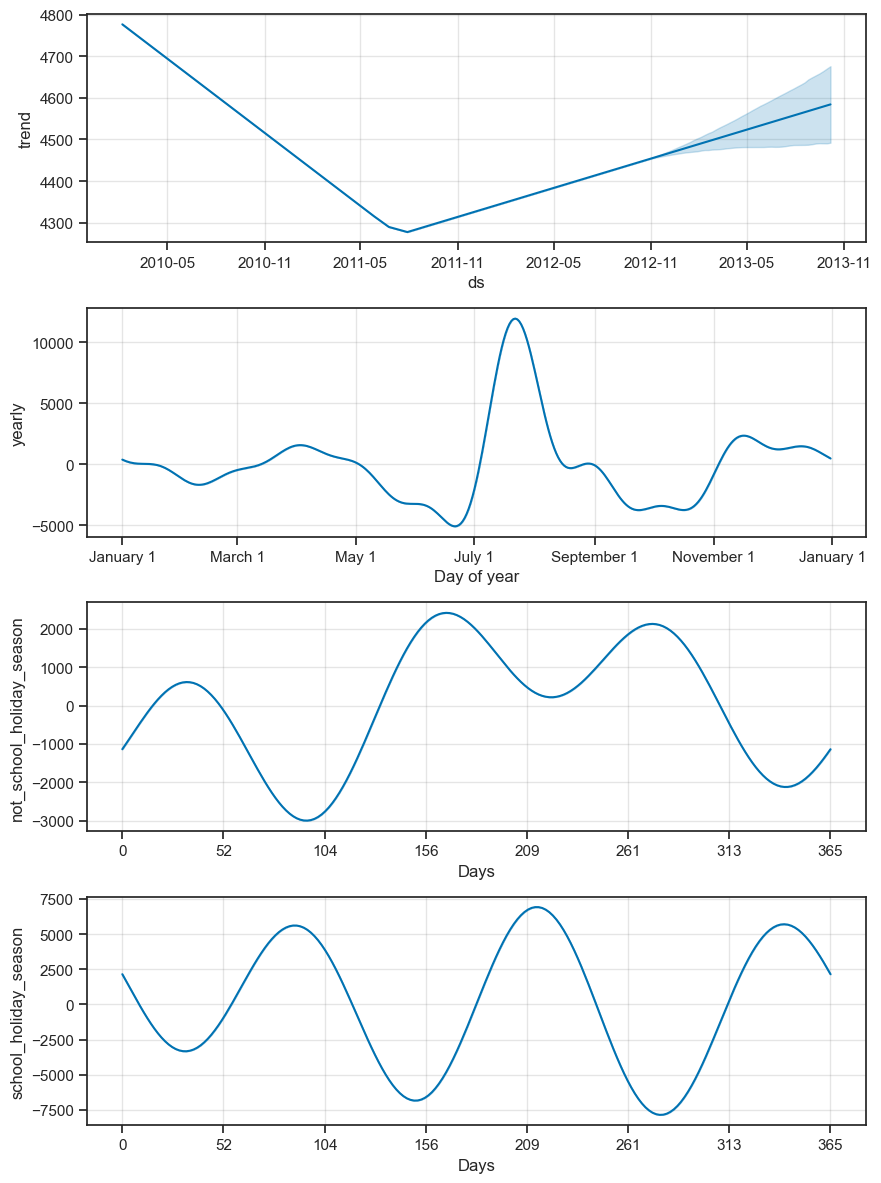

In [43]:
model.plot_components(forecast);